<a href="https://colab.research.google.com/github/TheCaveOfAdullam/study3/blob/main/pruningModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow_model_optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 2.0 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import os
import time
import psutil
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.utils import to_categorical
import keras.backend as K
import h5py
from keras.regularizers import l2
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import random
import gc
import tensorflow_model_optimization as tfmot
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

In [4]:
# 시드 설정
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# 환경 변수 설정 (결정론적 연산 보장)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [5]:
# 기본 경로 설정
base_dir = '/content/drive/MyDrive/ship_data'
categories = ['normal', 'fault_BB', 'fault_RI', 'fault_SM']

# 데이터 로드 및 전처리 함수 정의
def load_data(base_dir, split):
    X = []
    y = []
    split_dir = os.path.join(base_dir, split)
    for category in categories:
        category_dir = os.path.join(split_dir, category)
        for file in os.listdir(category_dir):
            file_path = os.path.join(category_dir, file)
            data = pd.read_csv(file_path, header=None).values
            data = pd.to_numeric(data.flatten(), errors='coerce').reshape(-1, data.shape[1])
            data = np.nan_to_num(data).astype('float32')  # NaN 값을 0으로 대체하고, float32로 변환
            X.append(data)
            y.append(category)
    return np.array(X), np.array(y)

# 데이터 로드
X_train, y_train = load_data(base_dir, 'train')
X_val, y_val = load_data(base_dir, 'validation')
X_test, y_test = load_data(base_dir, 'test')

# 데이터 차원 변경 (CNN 입력 형식에 맞게)
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# 레이블 인코딩
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# 원-핫 인코딩
y_train_categorical = to_categorical(y_train_encoded)
y_val_categorical = to_categorical(y_val_encoded)
y_test_categorical = to_categorical(y_test_encoded)

In [31]:
def create_model():
    model = Sequential(name='CNN_Model')
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu',
                     input_shape=(X_train.shape[1], X_train.shape[2]), name='conv1'))
    model.add(MaxPooling1D(pool_size=2, name='maxpool1'))

    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', name='conv2'))
    model.add(MaxPooling1D(pool_size=2, name='maxpool2'))

    model.add(Flatten(name='flatten'))
    model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.0001), name='dense1'))  # Dense 레이어에 L2 정규화
    model.add(Dropout(0.3, name='dropout'))
    model.add(Dense(len(categories), activation='softmax', name='output'))

    return model

# Create and compile the model
model = create_model()
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
# Train the model and capture the history
history = model.fit(X_train, y_train_categorical, epochs=5, batch_size=32, validation_data=(X_val, y_val_categorical))

Epoch 1/5
219/219 [==============================] - 77s 348ms/step - loss: 1.6788 - accuracy: 0.4989 - val_loss: 0.7578 - val_accuracy: 0.7433
Epoch 2/5
219/219 [==============================] - 76s 347ms/step - loss: 0.7000 - accuracy: 0.7123 - val_loss: 0.6759 - val_accuracy: 0.7230
Epoch 3/5
219/219 [==============================] - 76s 348ms/step - loss: 0.5445 - accuracy: 0.7928 - val_loss: 0.2483 - val_accuracy: 0.9797
Epoch 4/5
219/219 [==============================] - 76s 349ms/step - loss: 0.4485 - accuracy: 0.8385 - val_loss: 0.3236 - val_accuracy: 0.8858
Epoch 5/5
219/219 [==============================] - 77s 351ms/step - loss: 0.4371 - accuracy: 0.8377 - val_loss: 0.2184 - val_accuracy: 0.9319


In [33]:
# 원래 모델 저장
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [34]:
# 가지치기 함수 정의
def prune_weights(model, pruning_percentage=0.9):
    for layer in model.layers:
        if isinstance(layer, Dense):
            weights, biases = layer.get_weights()

            # 가중치의 절대값 기준으로 임계값 계산
            abs_weights = np.abs(weights)
            threshold = np.percentile(abs_weights, pruning_percentage * 100)

            # 임계값 이하의 가중치를 0으로 설정
            new_weights = np.where(abs_weights < threshold, 0, weights)

            # 가지치기된 가중치로 레이어 설정
            layer.set_weights([new_weights, biases])

    return model

# 가지치기된 모델
pruned_model = prune_weights(model, pruning_percentage=0.9)

In [35]:
# 가지치기된 모델 재훈련
pruned_history = pruned_model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

pruned_history = pruned_model.fit(X_train, y_train_categorical, epochs=5, batch_size=32, validation_data=(X_val, y_val_categorical))

Epoch 1/5
219/219 [==============================] - 79s 358ms/step - loss: 0.3064 - accuracy: 0.9036 - val_loss: 0.1361 - val_accuracy: 0.9820
Epoch 2/5
219/219 [==============================] - 77s 353ms/step - loss: 0.1606 - accuracy: 0.9676 - val_loss: 0.0678 - val_accuracy: 1.0000
Epoch 3/5
219/219 [==============================] - 78s 357ms/step - loss: 0.1207 - accuracy: 0.9803 - val_loss: 0.0705 - val_accuracy: 0.9961
Epoch 4/5
219/219 [==============================] - 78s 355ms/step - loss: 0.1288 - accuracy: 0.9742 - val_loss: 0.0939 - val_accuracy: 0.9969
Epoch 5/5
219/219 [==============================] - 78s 356ms/step - loss: 0.1259 - accuracy: 0.9774 - val_loss: 0.1137 - val_accuracy: 0.9734


In [36]:
# 가지치기된 모델의 가중치 저장 (희소성 적용)
def save_sparse_model(model, file_path):
    with h5py.File(file_path, 'w') as f:
        for layer in model.layers:
            if isinstance(layer, Dense) or isinstance(layer, Conv1D):
                weights, biases = layer.get_weights()
                # 0이 아닌 가중치만 저장
                non_zero_indices = weights != 0
                non_zero_weights = weights[non_zero_indices]
                f.create_dataset(layer.name + '_weights', data=non_zero_weights)
                f.create_dataset(layer.name + '_biases', data=biases)
                f.create_dataset(layer.name + '_non_zero_indices', data=non_zero_indices)
            else:
                # 다른 레이어는 그대로 저장
                weights = layer.get_weights()
                for i, weight in enumerate(weights):
                    f.create_dataset(layer.name + f'_weights_{i}', data=weight)

# 희소성 적용한 모델 저장
save_sparse_model(pruned_model, 'model_after_pruning_sparse.h5')

# 희소성 적용 모델 로드 함수
def load_sparse_model(file_path, original_model):
    with h5py.File(file_path, 'r') as f:
        for layer in original_model.layers:
            if isinstance(layer, Dense) or isinstance(layer, Conv1D):
                non_zero_weights = f[layer.name + '_weights'][:]
                biases = f[layer.name + '_biases'][:]
                non_zero_indices = f[layer.name + '_non_zero_indices'][:]
                original_weights = np.zeros(layer.get_weights()[0].shape)
                original_weights[non_zero_indices] = non_zero_weights
                layer.set_weights([original_weights, biases])
            else:
                weights = []
                i = 0
                while f'{layer.name}_weights_{i}' in f:
                    weights.append(f[layer.name + f'_weights_{i}'][:])
                    i += 1
                layer.set_weights(weights)

# 희소성 적용 모델 로드
model_for_evaluation = create_model()
load_sparse_model('model_after_pruning_sparse.h5', model_for_evaluation)

# 모델 컴파일
model_for_evaluation.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
# 모델 크기 비교
original_model_size = os.path.getsize('model.h5') / (1024 * 1024)
sparse_model_size = os.path.getsize('model_after_pruning_sparse.h5') / (1024 * 1024)
print(f"Original Model Size: {original_model_size:.2f} MB")
print(f"Sparse Pruned Model Size: {sparse_model_size:.2f} MB")

Original Model Size: 439.50 MB
Sparse Pruned Model Size: 77.69 MB


In [38]:
# 검증 데이터 평가
val_loss_after, val_accuracy_after = model_for_evaluation.evaluate(X_val, y_val_categorical)
print(f"Validation Loss: {val_loss_after:.4f}")
print(f"Validation Accuracy: {val_accuracy_after:.4f}")

40/40 [==============================] - 3s 73ms/step - loss: 0.1137 - accuracy: 0.9734
Validation Loss: 0.1137
Validation Accuracy: 0.9734


In [39]:
# 테스트 데이터 평가
test_loss_after, test_accuracy_after = model_for_evaluation.evaluate(X_test, y_test_categorical)
print(f"Test Loss: {test_loss_after:.4f}")
print(f"Test Accuracy: {test_accuracy_after:.4f}")

40/40 [==============================] - 3s 73ms/step - loss: 0.1277 - accuracy: 0.9687
Test Loss: 0.1277
Test Accuracy: 0.9687


In [40]:
# 테스트 데이터 평가
test_loss, test_accuracy = model.evaluate(X_test, y_test_categorical)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

40/40 [==============================] - 3s 71ms/step - loss: 0.1277 - accuracy: 0.9687
Test Loss: 0.1277279257774353
Test Accuracy: 0.9687011241912842


In [41]:
# 혼동 행렬 및 성능 지표 출력 (테스트 데이터)
y_pred_after = model_for_evaluation.predict(X_test)
y_pred_after = np.argmax(y_pred_after, axis=1)
conf_matrix_test_after = confusion_matrix(y_test_encoded, y_pred_after)

40/40 [==============================] - 3s 72ms/step


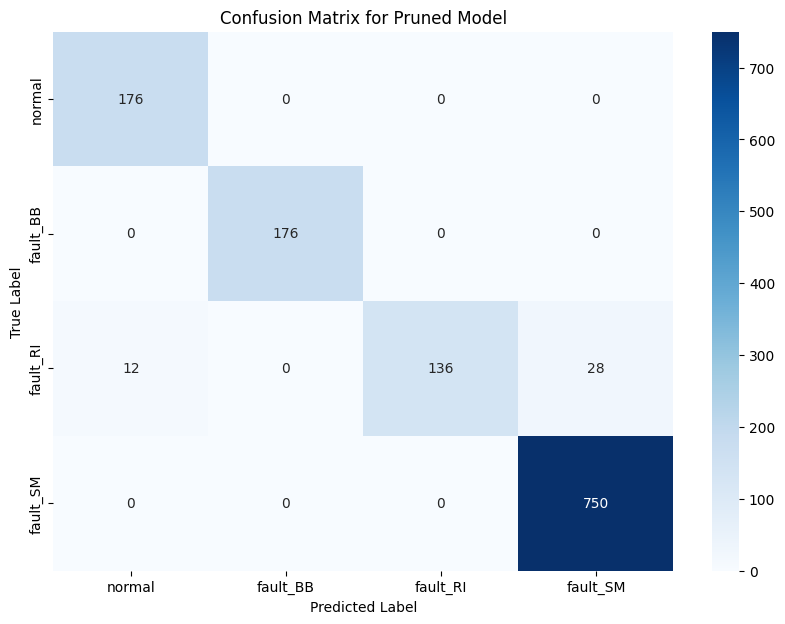

In [42]:
# 혼동 행렬 시각화
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_test_after, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Pruned Model')
plt.show()

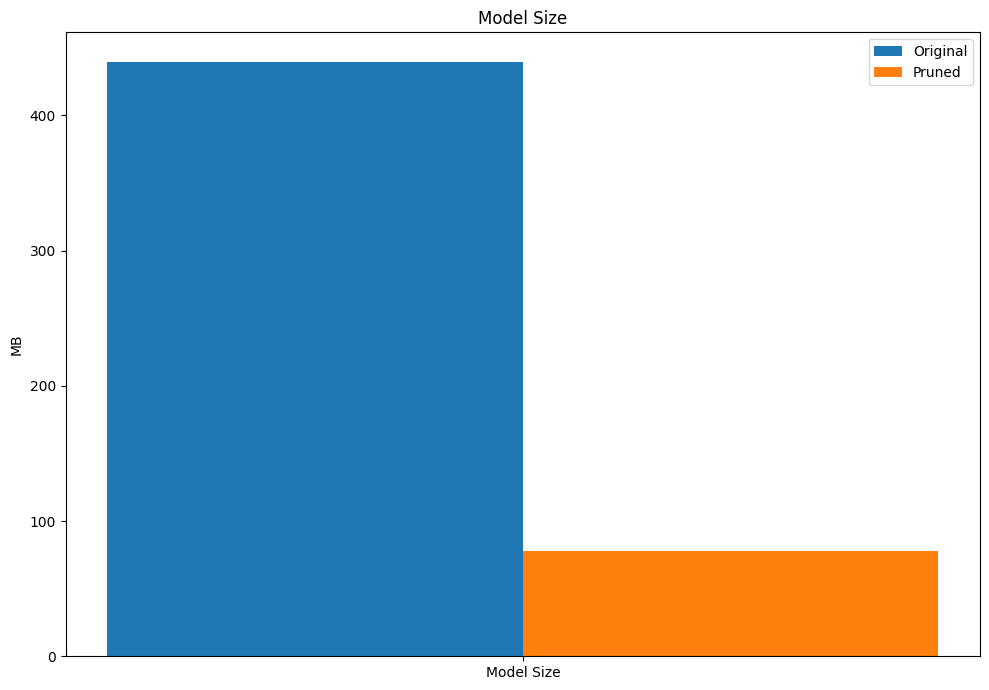

In [43]:
# 모델 사이즈 비교 막대 그래프
labels = ['Model Size']
original_values = [original_model_size]
pruned_values = [sparse_model_size]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 7))
rects1 = ax.bar(x - width/2, original_values, width, label='Original')
rects2 = ax.bar(x + width/2, pruned_values, width, label='Pruned')

ax.set_ylabel('MB')
ax.set_title('Model Size')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()

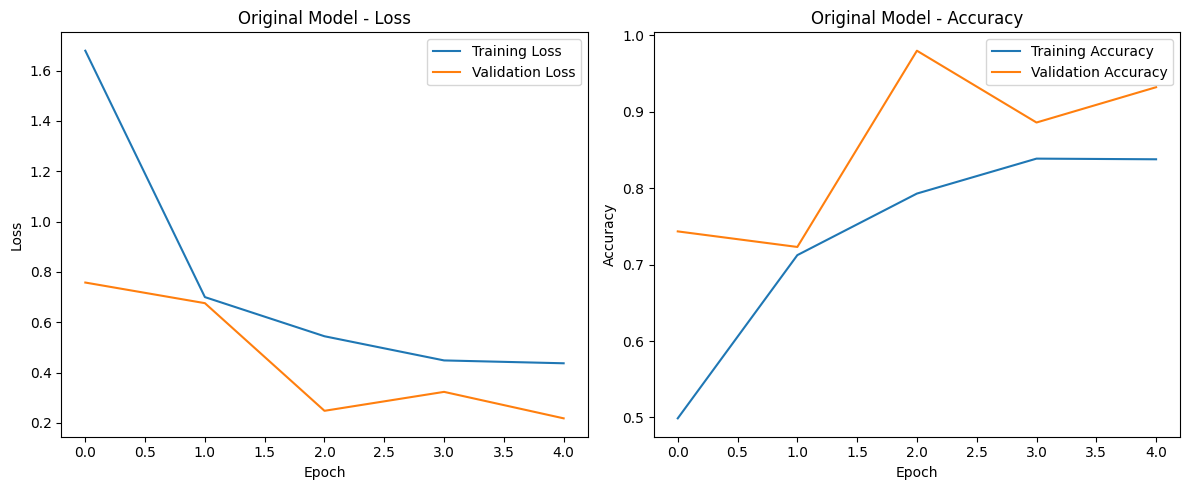

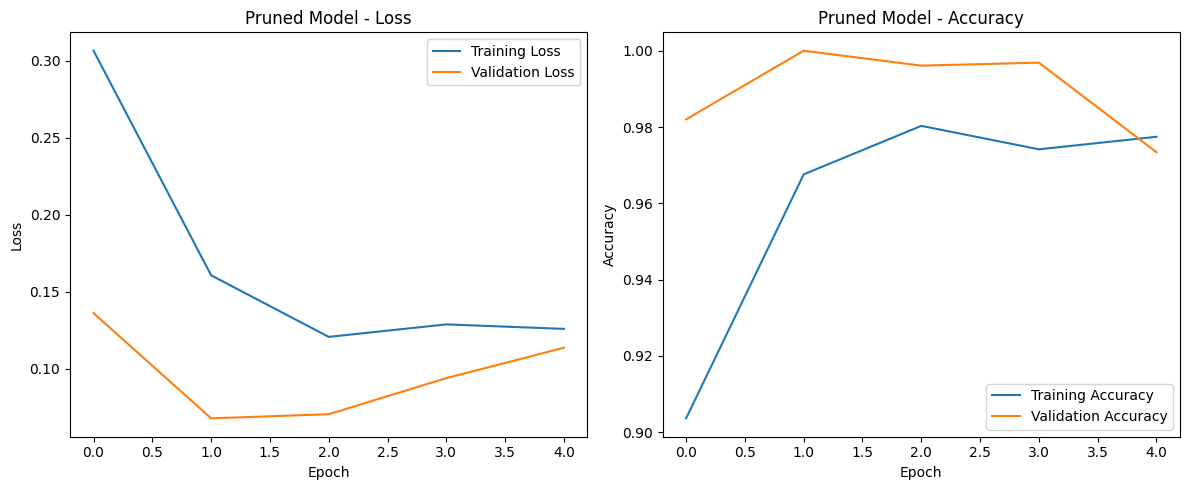

In [44]:
# 모델 학습 과정 시각화
def plot_training_history(history, title):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title + ' - Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(title + ' - Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history, 'Original Model')
plot_training_history(pruned_history, 'Pruned Model')

In [45]:
# 성능 평가
y_pred = model_for_evaluation.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val_categorical, axis=1)

40/40 [==============================] - 3s 70ms/step


In [46]:
# 정확도 계산
accuracy = accuracy_score(y_true, y_pred_classes)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9734


In [47]:
# 정밀도 계산
precision = precision_score(y_true, y_pred_classes, average='weighted')
print(f'Precision: {precision:.4f}')

Precision: 0.9744


In [48]:
# 재현율 계산
recall = recall_score(y_true, y_pred_classes, average='weighted')
print(f'Recall: {recall:.4f}')

Recall: 0.9734


In [49]:
# F1 스코어 계산
f1 = f1_score(y_true, y_pred_classes, average='weighted')
print(f'F1 Score: {f1:.4f}')

F1 Score: 0.9722


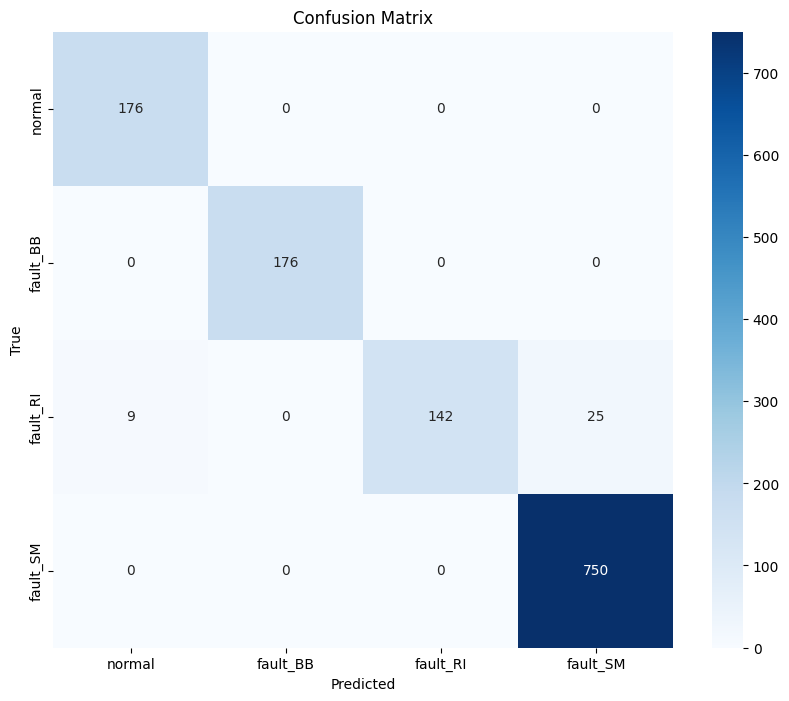

In [50]:
# 혼동 행렬 계산 및 시각화
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

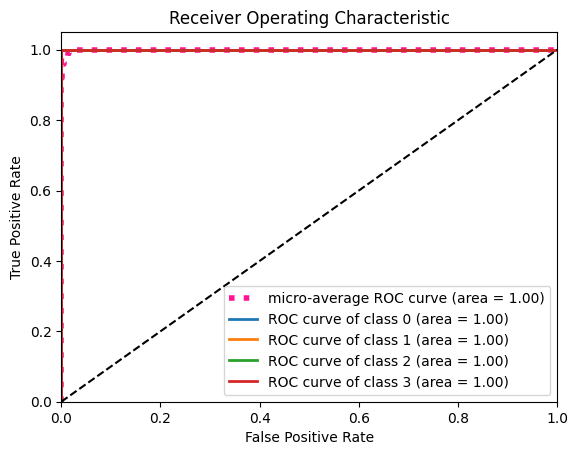

In [51]:
# ROC-AUC 계산 및 시각화
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(categories)):
    fpr[i], tpr[i], _ = roc_curve(y_val_categorical[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 전체 ROC 커브
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_categorical.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4, label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))
for i in range(len(categories)):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [52]:
# 정밀도-재현율 곡선 계산 및 시각화
precision = {}
recall = {}
pr_auc = {}

for i in range(len(categories)):
    precision[i], recall[i], _ = precision_recall_curve(y_val_categorical[:, i], y_pred[:, i])
    pr_auc[i] = auc(recall[i], precision[i])

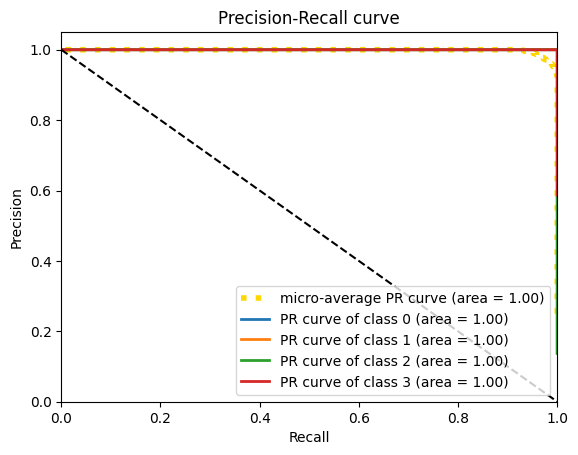

In [53]:
# 전체 PR 커브
precision["micro"], recall["micro"], _ = precision_recall_curve(y_val_categorical.ravel(), y_pred.ravel())
pr_auc["micro"] = auc(recall["micro"], precision["micro"])

plt.figure()
plt.plot(recall["micro"], precision["micro"], color='gold', linestyle=':', linewidth=4, label='micro-average PR curve (area = {0:0.2f})'.format(pr_auc["micro"]))
for i in range(len(categories)):
    plt.plot(recall[i], precision[i], lw=2, label='PR curve of class {0} (area = {1:0.2f})'.format(i, pr_auc[i]))

plt.plot([0, 1], [1, 0], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower right")
plt.show()

In [54]:
# FLOPs 계산 함수
def get_flops(model):
    concrete_function = tf.function(lambda x: model(x))
    concrete_function = concrete_function.get_concrete_function(
        tf.TensorSpec([1] + list(model.input_shape[1:]), model.inputs[0].dtype))

    frozen_func = convert_variables_to_constants_v2(concrete_function)
    frozen_graph = frozen_func.graph.as_graph_def()

    with tf.Graph().as_default() as graph:
        tf.import_graph_def(frozen_graph, name='')

        # 프로파일링을 위한 런 옵션 설정
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()

        # 세션을 사용하여 프로파일링
        with tf.compat.v1.Session(graph=graph) as sess:
            flops = tf.compat.v1.profiler.profile(graph=graph, options=opts)

    return flops.total_float_ops

In [55]:
# 모델 플롭스 계산
flops = get_flops(model_for_evaluation)
print(f"FLOPs: {flops:,}")

FLOPs: 383,800,412
